In [1]:
import numpy as np
import pandas as pd 
from scipy import stats
import warnings

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt
import seaborn as sns

import time
start_time = time.time()
%matplotlib inline

In [2]:
# Import the housing dataset as a Pandas Dataframe
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Create a summmary of each column in the df
print(df.info())

print('''
yr_renovated and waterfront are only columns containing null values
''')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Find average house price and base RMSE using average price per sqft

In [4]:
# Calculates the average price of houses
avg_price_house = df.price.mean()
avg_price_house

540296.5735055795

In [5]:
# Calculates the average price per square feet
avg_price_sqft = (df.price / df.sqft_living).mean()
avg_price_sqft

264.1433683790251

In [6]:
# EDA checking if square feet is a strong predictor of housing price
price_pred_base = df.sqft_living * avg_price_sqft
rmse_base = mean_squared_error(df.price, price_pred_base, squared=False)

# Very high rmse, livable square footage isn't a strong predictor
round(rmse_base, 0)

262267.0

## Data Cleaning

In [7]:
# Set Nan values of 'waterfront' and 'year_renovated' columns to 0
df.loc[df.waterfront.isna()==True, 'waterfront'] = 0
df.loc[df.yr_renovated.isna()==True, 'yr_renovated'] = 0

#Set all sqft_basement values of '?' to 0, then convert to floats.
df.loc[df.sqft_basement=='?', 'sqft_basement'] = 0
df.sqft_basement = df.sqft_basement.astype(float)

# Convert 'date' to a datetime object and use these to create a 'year' column
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda date: date.year)

# Create an 'age' column to specify how old a house was at sale
df['age'] = df['year'] - df['yr_built']

#Drop unnecessary 'id', 'yr_built', 'year', and 'date' columns
cols_to_drop = ['id', 'yr_built', 'year', 'date']
df.drop(cols_to_drop, axis=1, inplace=True)

#Drop rows that contain null values in the 'view' column
df.dropna(subset = ['view'], inplace = True)

## Handling Outliers

In [8]:
# assigning variable for columns we would like to check for outliers
target_cols = ['bathrooms', 'bedrooms', 'sqft_living']

# assigning variable to predefined outlier column names
outlier_cols = ['outlier_' + col for col in target_cols]
z_scores = [stats.zscore(df[col]) 
                for col in target_cols]

# for each column, checking to see if the z-score is above or below 3 standard deviations
for outlier_col, z_score in zip(outlier_cols, z_scores):
    df[outlier_col] = ((z_score > 3) | (z_score <-3))

# initializes an empty query string 
query_empty = '({} == False)&'*(len(target_cols))

# fills in the outlier column names
query = query_empty[:-1].format(*outlier_cols)

# selecting rows that do not have any outliers
df = df.query(query)

# dropping the outlier columns that we just made
df = df.drop(columns=outlier_cols)

# Drop the outlier house that contains 33 bedrooms
df = df[df['bedrooms'] != 33]

# Drop houses that were bought before construction
df = df[df['age'] != -1]

There is a relatively normal distribution of bedroom sizes


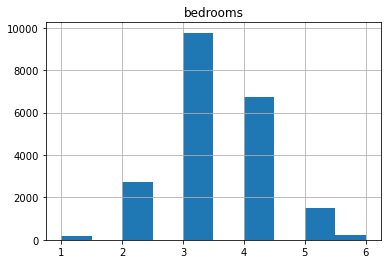

In [9]:
# plotting a histogram to visualize the # of homes sold by # of bedrooms
df.hist('bedrooms');
print('There is a relatively normal distribution of bedroom sizes')

Price has a positive skew


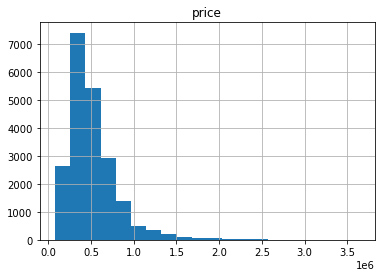

In [10]:
# plotting a histogram to visualize the # of homes sold by price
print("Price has a positive skew")
df.hist('price', bins=20);

In [11]:
# Create a matrix of correlations for each feature set in the dataframe
corr_matrix = df.corr()
# Create a boolean mask for all values on or above the matrix diagonal 
corr_matrix_mask = np.triu(np.ones_like(df.corr(), dtype=bool));

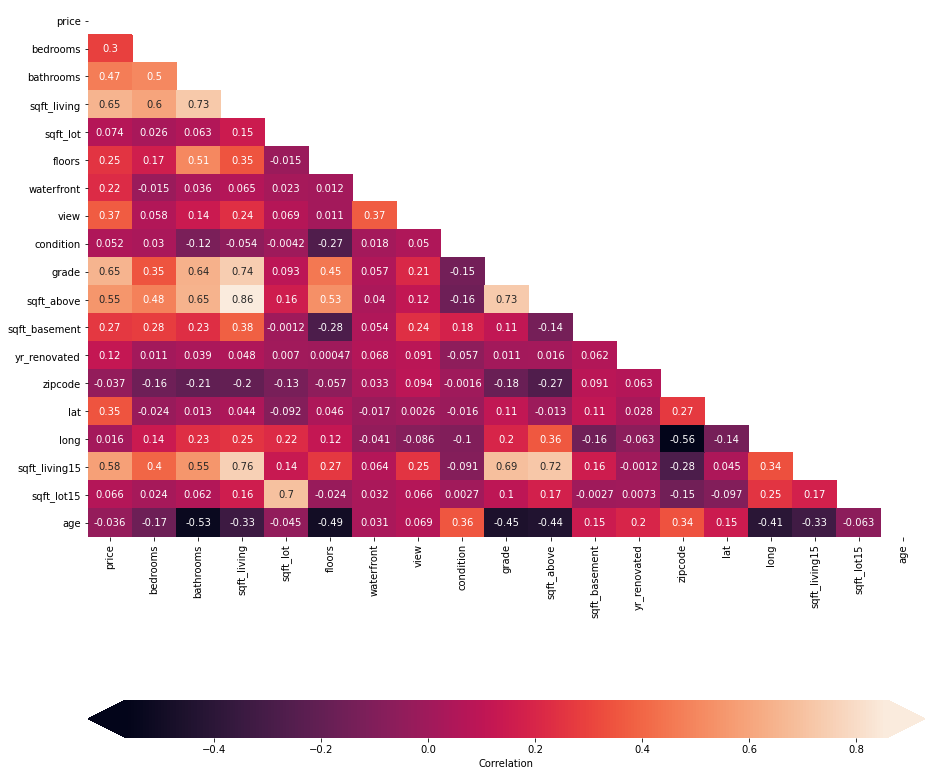

In [12]:
# Creates a heat map of correlation coefficient
fig, ax = plt.subplots(figsize  =(15,15))
sns.heatmap(
            corr_matrix, 
            ax=ax, 
            annot=True, 
            mask= corr_matrix_mask,
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
);

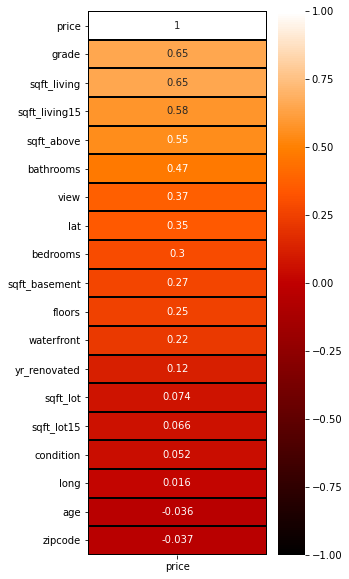

In [13]:
# Price will be our target value to predict, so we'll zero in on its correlations.
plt.figure(figsize=(4,10))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, linewidths=1, linecolor='black', annot=True, fmt='.2g', cmap="gist_heat")

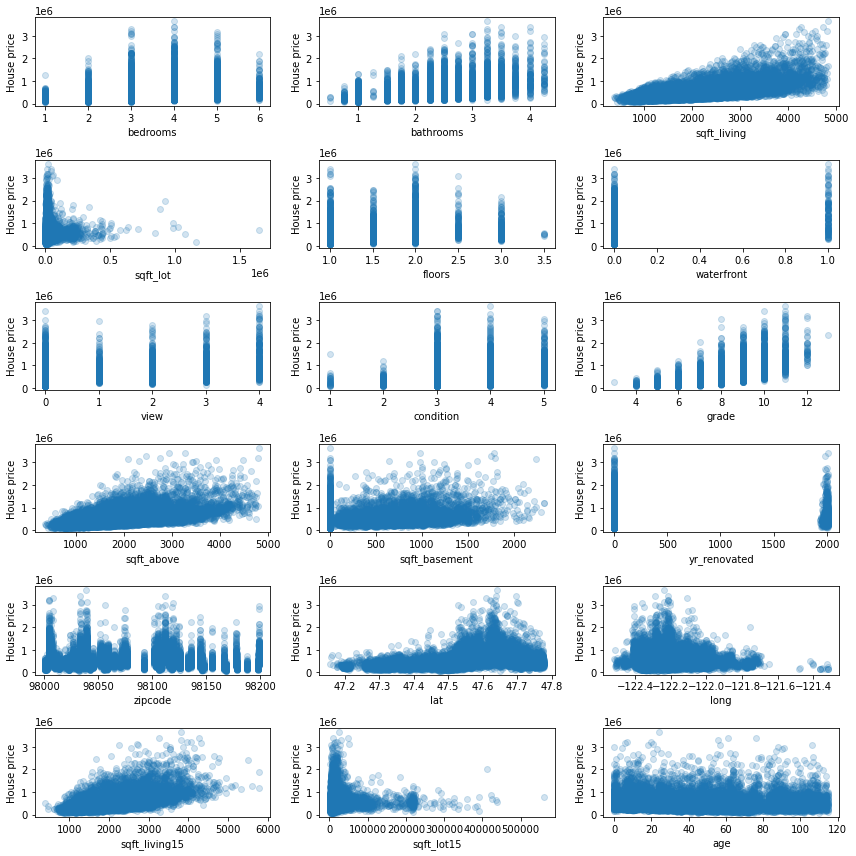

In [14]:
# Creating visualizations for each of our features as they relate to the price of houses sold in our dataset

x = df.drop('price', axis=1)
y= df.price
fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(12, 12))
fig.set_tight_layout(True)
for index, col in enumerate(x.columns): 
    ax = axes[index//3][index%3]
    ax.scatter(x[col], y, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("House price")

### Average Sqft Per Price Range

Text(0.5, 1.0, 'Average Livable Space by Price Range')

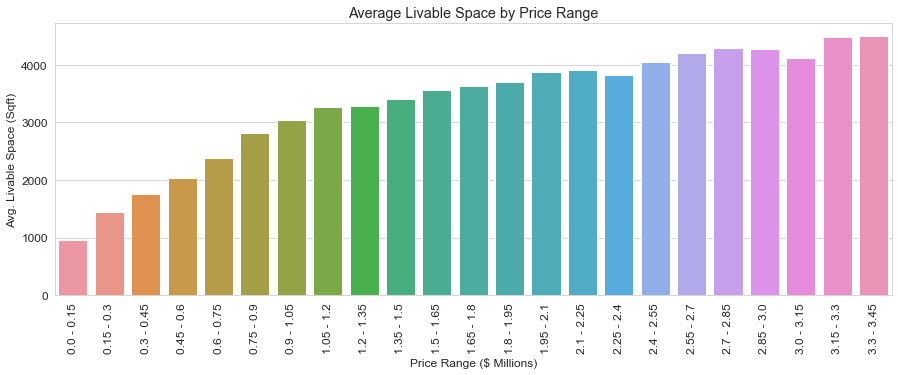

In [15]:
# Creates the binning intervals for price
bins = pd.interval_range(0,df.price.max(), freq=150000)

# Creates a column where price values are sorted into bins
df['price_bins'] = pd.cut(df.price, bins)

# Finds the mean square footage for each price bin for each price bin
grouped_means = df.groupby("price_bins")['sqft_living'].mean()
grouped_means = grouped_means.reset_index().dropna(subset=['sqft_living'])

# Breaks up the bins into a readable format for plotting
x_labels = [str(interval.left/1000000) + ' - ' + str(interval.right/1000000)
            for interval in grouped_means['price_bins']
           ]
# Overwrite raw bins with readable format for easy plotting
grouped_means['price_bins'] = x_labels

# Initializes plot and style parameters
plt.rc('font', size=12) 
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (15, 5))

# Plots price bins and average livable space
ax = sns.barplot(y='sqft_living',x='price_bins', data=grouped_means)

# Modify plot label attributes
plt.xticks(rotation=90)
ax.set(xlabel='Price Range ($ Millions)', ylabel='Avg. Livable Space (Sqft)')
plt.title("Average Livable Space by Price Range")

### Average price by Grade

Text(0.5, 1.0, 'Average Home Price by Grade')

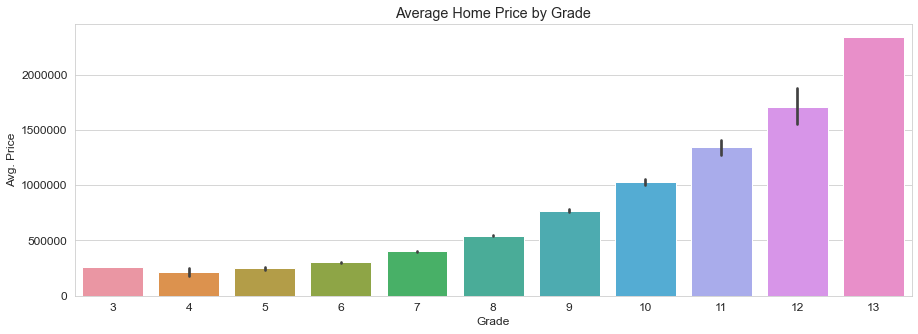

In [16]:
# Creating a visualization to understand the mean price of homes sold by each value for grade

# Initializes plot and style parameters
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (15, 5))

# Creates a bar plot of our target params
x = df['grade']
y = df['price']
ax = sns.barplot(x=x,y=y, data=df)

# Modify plot label attributes
ax.ticklabel_format(style='plain', axis='y')
ax.set(xlabel='Grade', ylabel='Avg. Price')
plt.title("Average Home Price by Grade")

### Average Price by bathrooms

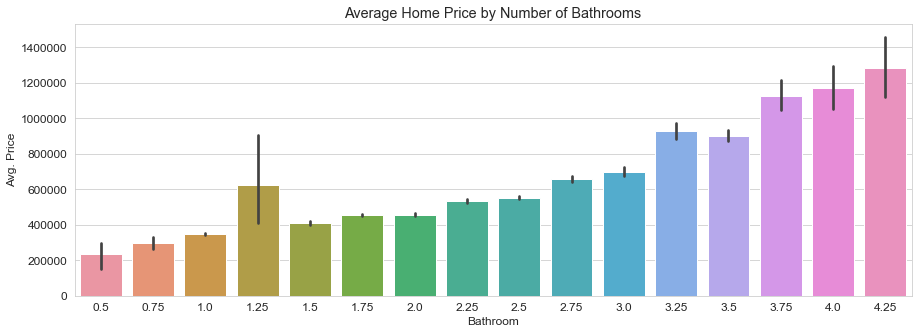

In [17]:
# Creating a visualization to understand the mean price of homes sold by number of bathrooms

# Initializes plot and style parameters
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (15, 5))

# Creates a bar plot of our target params
x = df['bathrooms']
y = df['price']
ax = sns.barplot(x=x,y=y, data=df)

# Modify plot label attributes
ax.ticklabel_format(style='plain', axis='y')
ax.set(xlabel='Bathroom', ylabel='Avg. Price')
plt.title("Average Home Price by Number of Bathrooms")
plt.show()

### Average Price by View

Text(0.5, 1.0, 'Average Home Price by View')

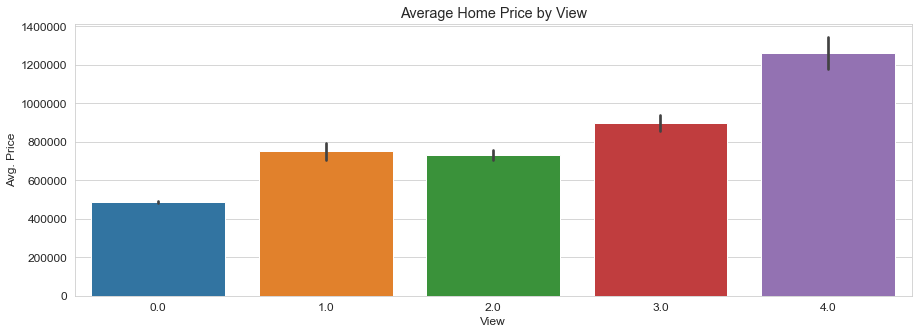

In [18]:
# Creating a visualization to understand the mean price of homes sold by number of views

# Initializes plot and style parameters
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (15, 5))

# Creates a bar plot of our target params
x = df['view']
y = df['price']
ax = sns.barplot(x=x,y=y, data=df)

# Modify plot label attributes
ax.ticklabel_format(style='plain', axis='y')
ax.set(xlabel='View', ylabel='Avg. Price')
plt.title("Average Home Price by View")

### Average Price by Condition

Text(0.5, 1.0, 'Average Home Price by Condition')

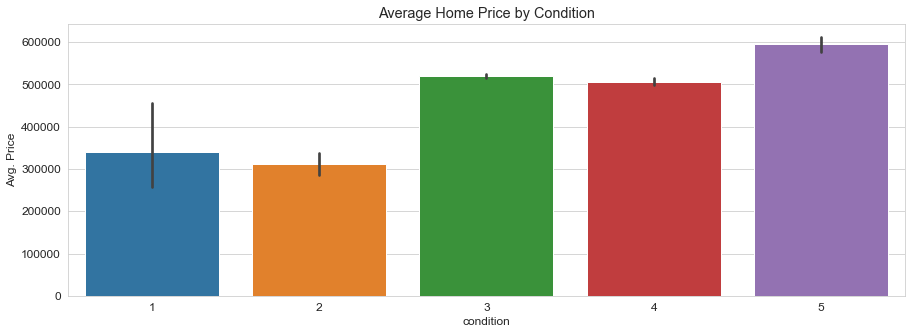

In [19]:
# Creating a visualization to understand the mean price of homes sold by condition

# Initializes plot and style parameters
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (15, 5))

# Creates a bar plot of our target params
x = df['condition']
y = df['price']
ax = sns.barplot(x=x,y=y, data=df)

# Modify plot label attributes
ax.ticklabel_format(style='plain', axis='y')
ax.set(xlabel='condition', ylabel='Avg. Price')
plt.title("Average Home Price by Condition")

### Average Price by Waterfront

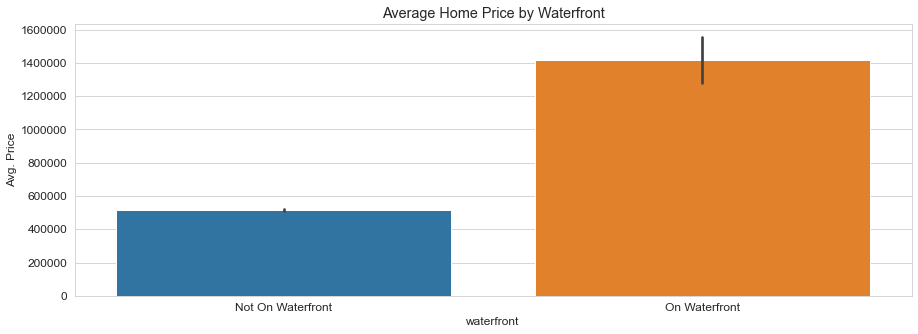

In [20]:
# Creating a visualization to understand the mean price of homes sold based on whether or not they are on the water

# Initializes plot and style parameters
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (15, 5))

# Creates a bar plot of our target params
x = df['waterfront']
y = df['price']
ax = sns.barplot(x=x,y=y, data=df)

# Modify plot label attributes
ax.ticklabel_format(style='plain', axis='y')
ax.set_xticklabels(['Not On Waterfront', 'On Waterfront'])
ax.set(xlabel='waterfront', ylabel='Avg. Price')
plt.title("Average Home Price by Waterfront")
plt.show()

### Scatterplot comparing sqft of neighbors to price

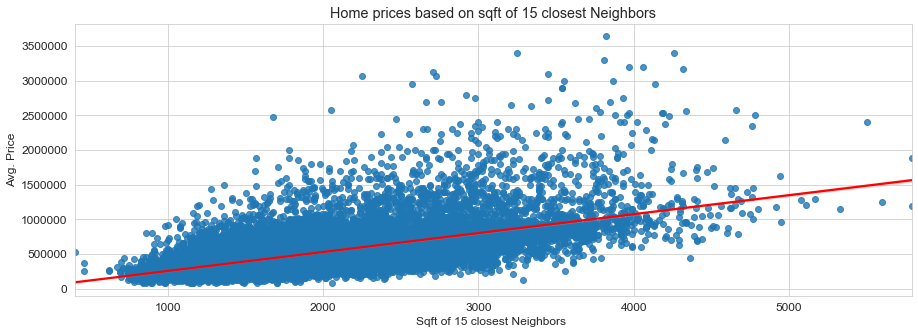

In [21]:
# Creating a visualization to understand the mean price of homes sold based on the 15 closest neighbors

# Initializes plot and style parameters
fig, ax = plt.subplots(figsize = (15, 5))

# Creates a bar plot of our target params
x = df['sqft_living15']
y = df['price']

ax = sns.regplot(x=x,y=y, data=df, line_kws={'color': 'r'})

# Modify plot label attributes
ax.ticklabel_format(style='plain', axis='y')
ax.set(xlabel='Sqft of 15 closest Neighbors ', ylabel='Avg. Price')
plt.title("Home prices based on sqft of 15 closest Neighbors")

plt.show()

### Barplot comparing sqft of neighbors to price

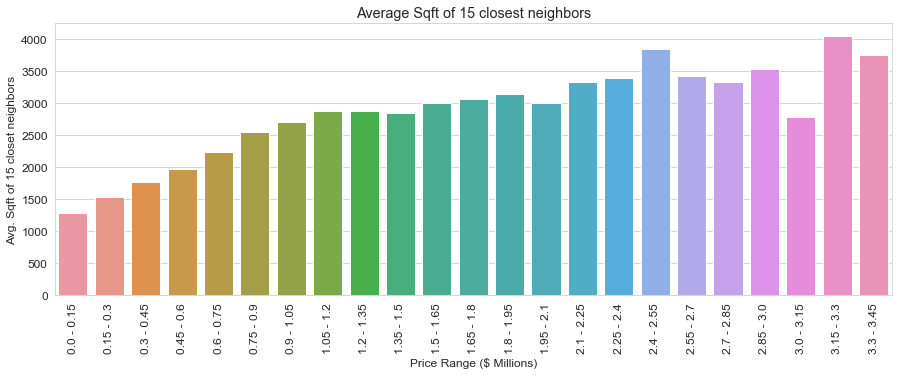

In [22]:
# Creates the binning intervals for price
bins = pd.interval_range(0,df.price.max(), freq=150000)

# Creates a column where price values are sorted into bins
df['price_bins'] = pd.cut(df.price, bins)

# Finds the mean square footage for the 15 closest neighbors for each price bin for each price bin
grouped_means = df.groupby("price_bins")['sqft_living15'].mean()
grouped_means = grouped_means.reset_index().dropna(subset=['sqft_living15'])

# Breaks up the bins into a readable format for plotting
x_labels = [str(interval.left/1000000) + ' - ' + str(interval.right/1000000)
            for interval in grouped_means['price_bins']
           ]

# Overwrite raw bins with readable format for easy plotting
grouped_means['price_bins'] = x_labels

# Initializes plot and style parameters
plt.rc('font', size=12) 
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (15, 5))

# Plots price bins and average livable space
ax = sns.barplot(y='sqft_living15',x='price_bins', data=grouped_means)

# Modify plot label attributes
plt.xticks(rotation=90)
ax.set(xlabel='Price Range ($ Millions)', ylabel='Avg. Sqft of 15 closet neighbors')
plt.title("Average Sqft of 15 closest neighbors");

# Model Building

## Baseline Model

In [23]:
df = df.drop('price_bins', axis = 1)

In [24]:
# Drop the new 'age' column and our target column 'price' for the independent features
X = df.drop(['price', 'age'], axis = 1)

# Set our dependent variable as price
y = df.price
  
# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Trains our model on our baseline values
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

# predicting test prices based on the X_test
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)

# Find the error of our dummy model
rmse_lr0 = mean_squared_error(y_test, y_predict_dummy_mean, squared=False)
print(r2_score(y_test, y_predict_dummy_mean), rmse_lr0)

-0.0001926534941929514 302249.8363238796


### Model 1:  including 'age'

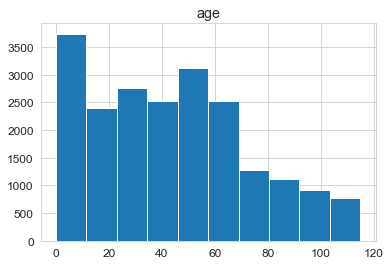

In [26]:
# plotting the # of homes sold by their age
df.hist('age');

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21132 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21132 non-null  float64
 1   bedrooms       21132 non-null  int64  
 2   bathrooms      21132 non-null  float64
 3   sqft_living    21132 non-null  int64  
 4   sqft_lot       21132 non-null  int64  
 5   floors         21132 non-null  float64
 6   waterfront     21132 non-null  float64
 7   view           21132 non-null  float64
 8   condition      21132 non-null  int64  
 9   grade          21132 non-null  int64  
 10  sqft_above     21132 non-null  int64  
 11  sqft_basement  21132 non-null  float64
 12  yr_renovated   21132 non-null  float64
 13  zipcode        21132 non-null  int64  
 14  lat            21132 non-null  float64
 15  long           21132 non-null  float64
 16  sqft_living15  21132 non-null  int64  
 17  sqft_lot15     21132 non-null  int64  
 18  age   

In [28]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as price
y = df['price']

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [29]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

# Predict price with the trained model
pred_lr1 = lr.predict(X_test)

# Get the coefficient of determination for training and test data
train_score_lr1 = lr.score(X_train, y_train)
test_score_lr1 = lr.score(X_test, y_test)

In [30]:
# Take a peak at model coef
lr.coef_[0]

-24532.171636512718

In [31]:
# Baseline housing cost without features
lr.intercept_

-2160858.7749652183

In [32]:
# Find the error of our predicted y test values
rmse_lr1 = mean_squared_error(y_test, pred_lr1, squared=False)

In [33]:
train_score_lr1, test_score_lr1, rmse_lr1

(0.6914587184752559, 0.6885558723559322, 168660.86272806223)

In [34]:
# Making an OLS table to check for feature significance
X_train = sm.add_constant(X_train)
sm.OLS(y_train, X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     2102.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        20:56:34   Log-Likelihood:            -2.2768e+05
No. Observations:               16905   AIC:                         4.554e+05
Df Residuals:                   16886   BIC:                         4.556e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.161e+06   2.77e+06     -0.780      0.436   -7.59e+06    3.27e+06
bedrooms      -2.453e+04   1992.633    -12.311      0.000   -2.84e+04   -2.06e+04
bathrooms      3.763e+04   3285.364     11.454      0.000    3.12e+04    4.41e+04
sqft_living      71.3276     18.630      3.829      0.000      34.811     107.844
sqft_lot          0.2068      0.046      4.481      0.000       0.116       0.297
floors         2.112e+04   3505.052      6.026      0.000    1.43e+04     2.8e+04
waterfront      4.97e+05   1.85e+04     26.828      0.000    4.61e+05    5.33e+05
view           5.412e+04   2089.791     25.895      0.000       5e+04    5.82e+04
condition      2.885e+04   2254.973     12.794      0.000    2.44e+04    3.33e+04
grade          9.753e+04   2108.901     46.248      0.000    9.34e+04    1.02e+05
sqft_above       49.1318     18.592      2.643      0.008      12.690      85.574
sqft_basement    30.5003     18.453      1.653      0.098      -5.669      66.670
yr_renovated     29.1342      3.835      7.598      0.000      21.618      36.651
zipcode        -476.8335     31.748    -15.019      0.000    -539.063    -414.604
lat            5.824e+05   1.03e+04     56.651      0.000    5.62e+05    6.03e+05
long          -1.671e+05   1.26e+04    -13.232      0.000   -1.92e+05   -1.42e+05
sqft_living15    51.0704      3.457     14.773      0.000      44.294      57.847
sqft_lot15       -0.2777      0.074     -3.776      0.000      -0.422      -0.134
age            2524.1126     69.384     36.379      0.000    2388.113    2660.112
==============================================================================
Omnibus:                     8995.197   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           150117.875
Skew:                           2.180   Prob(JB):                         0.00
Kurtosis:                      16.932   Cond. No.                     2.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
# Cross validate our model and find the mean of the training scores
scores_simple_1 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)

In [36]:
scores_simple_1

{'fit_time': array([0.00997257, 0.01097035, 0.01396275, 0.01097035, 0.00998616]),
 'score_time': array([0.00399613, 0.00398946, 0.00398946, 0.00299501, 0.00397563]),
 'test_score': array([0.69787506, 0.70047042, 0.66780262, 0.67796757, 0.70538398]),
 'train_score': array([0.68951916, 0.68907183, 0.69686387, 0.6946338 , 0.68777704])}

In [37]:
simple_1_mean = np.mean(scores_simple_1['train_score'])
simple_1_mean_test = np.mean(scores_simple_1['test_score'])

simple_1_mean, simple_1_mean_test

(0.6915731418531655, 0.6898999295200527)

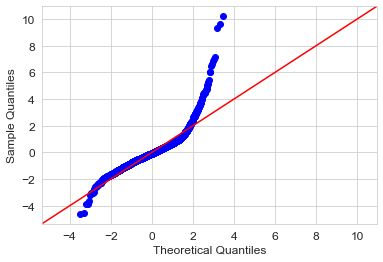

In [38]:
# Checking the QQ Plot to understand the distribution of residuals
residuals1 = (y_test - pred_lr1)
sm.graphics.qqplot(residuals1, dist=stats.norm, line="45", fit=True);

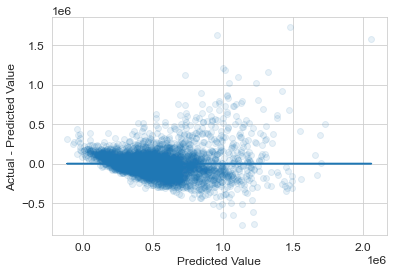

In [39]:
# Checking for homoscedasticity 

residuals1 = (y_test - pred_lr1)
fig, ax = plt.subplots()
ax.scatter(pred_lr1, residuals1, alpha=.1)
ax.plot(pred_lr1, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

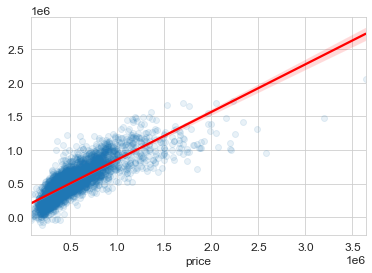

In [40]:
# Checking to see how our regression line fits our data
sns.regplot(x = y_test, y = pred_lr1, data = df, line_kws={'color':'r'}, scatter_kws={'alpha':0.1});

### Model 2: log transform 'price'

In [41]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

# Predict price with the trained model
pred_lr2 = lr.predict(X_test)

In [43]:
# Using the score method to see how well our model performed based on how we trained it
train_score_lr2 = lr.score(X_train, y_train)
test_score_lr2 = lr.score(X_test, y_test)

In [44]:
# Take a peak at model coef
lr.coef_[0] 

-0.01798952328017328

In [45]:
# Baseline housing cost without features
lr.intercept_

-13.94477759740219

In [46]:
# Normalizing our price to get an RMSE
rmse_lr2 = mean_squared_error(np.exp(y_test), np.exp(pred_lr2), squared=False)

In [47]:
train_score_lr2, test_score_lr2, rmse_lr2 

(0.7558928001010055, 0.7516799842032745, 164378.8858748426)

In [48]:
# Making an OLS table to check for feature significance
X_train = sm.add_constant(X_train)
sm.OLS(y_train, X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     2905.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        20:56:35   Log-Likelihood:                -486.12
No. Observations:               16905   AIC:                             1010.
Df Residuals:                   16886   BIC:                             1157.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -13.9448      4.035     -3.456      0.001     -21.855      -6.035
bedrooms         -0.0180      0.003     -6.200      0.000      -0.024      -0.012
bathrooms         0.0785      0.005     16.404      0.000       0.069       0.088
sqft_living       0.0002   2.71e-05      5.823      0.000       0.000       0.000
sqft_lot       5.494e-07   6.72e-08      8.176      0.000    4.18e-07    6.81e-07
floors            0.0742      0.005     14.535      0.000       0.064       0.084
waterfront        0.3754      0.027     13.918      0.000       0.323       0.428
view              0.0646      0.003     21.243      0.000       0.059       0.071
condition         0.0592      0.003     18.019      0.000       0.053       0.066
grade             0.1577      0.003     51.358      0.000       0.152       0.164
sqft_above     -4.91e-06   2.71e-05     -0.181      0.856    -5.8e-05    4.82e-05
sqft_basement   7.81e-06   2.69e-05      0.291      0.771   -4.49e-05    6.05e-05
yr_renovated   3.835e-05   5.58e-06      6.869      0.000    2.74e-05    4.93e-05
zipcode          -0.0006   4.62e-05    -13.059      0.000      -0.001      -0.001
lat               1.3849      0.015     92.523      0.000       1.356       1.414
long             -0.1474      0.018     -8.018      0.000      -0.183      -0.111
sqft_living15   9.59e-05   5.03e-06     19.051      0.000     8.6e-05       0.000
sqft_lot15    -1.726e-07   1.07e-07     -1.612      0.107   -3.83e-07    3.73e-08
age               0.0037      0.000     36.401      0.000       0.003       0.004
==============================================================================
Omnibus:                      240.179   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              454.612
Skew:                          -0.014   Prob(JB):                     1.92e-99
Kurtosis:                       3.803   Cond. No.                     2.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

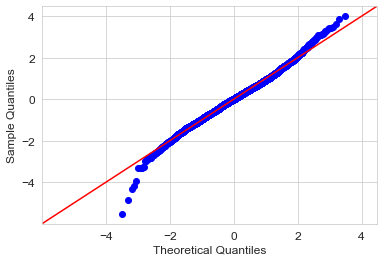

In [49]:
# Checking the QQ Plot to understand the distribution of residuals
residuals2 = (y_test - pred_lr2)
sm.graphics.qqplot(residuals2, dist=stats.norm, line="45", fit=True);

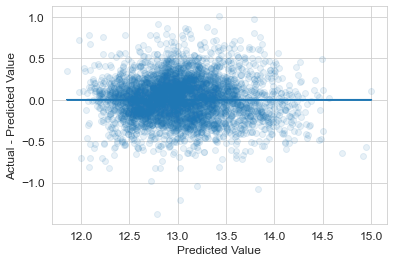

In [50]:
# Checking for homoscedasticity 
residuals2 = (y_test - pred_lr2)
fig, ax = plt.subplots()
ax.scatter(pred_lr2, residuals2, alpha=.1)
ax.plot(pred_lr2, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

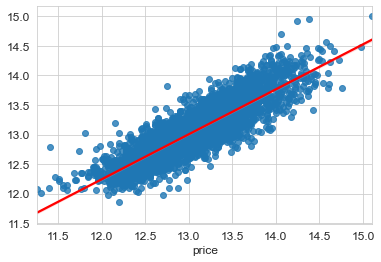

In [51]:
# Checking to see how our regression line fits our data
sns.regplot(x = y_test, y = pred_lr2, data = df, line_kws={'color':'r'});

In [52]:
# Cross validate our model and find the mean of the training scores
scores_simple_2 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)

In [53]:
scores_simple_2

{'fit_time': array([0.01000404, 0.00797844, 0.00897646, 0.01100016, 0.0109868 ]),
 'score_time': array([0.00296259, 0.00299144, 0.00498796, 0.00395942, 0.00397372]),
 'test_score': array([0.76097965, 0.75886196, 0.73974692, 0.75016066, 0.76491888]),
 'train_score': array([0.75438505, 0.755087  , 0.75968499, 0.75722842, 0.75344478])}

In [54]:
simple_2_mean = np.mean(scores_simple_2['train_score'])
simple_2_mean_test = np.mean(scores_simple_2['test_score'])

In [55]:
simple_2_mean, simple_2_mean_test

(0.7559660463151505, 0.7549336128000153)

### Checking the VIF Score

In [56]:
# Making a constant column
df_temp = sm.add_constant(df)

# Checking the Multicollinearity between the features
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_temp.values, i) for i in range(df_temp.values.shape[1])]
vif["features"] = df_temp.columns

print(vif.round(1))

    VIF Factor       features
0    4439044.0          const
1          3.2          price
2          1.7       bedrooms
3          3.2      bathrooms
4        131.9    sqft_living
5          2.0       sqft_lot
6          2.1         floors
7          1.2     waterfront
8          1.4           view
9          1.3      condition
10         3.6          grade
11       113.7     sqft_above
12        34.4  sqft_basement
13         1.1   yr_renovated
14         1.7        zipcode
15         1.4            lat
16         1.8           long
17         3.0  sqft_living15
18         2.0     sqft_lot15
19         2.6            age


### Model 3:  creating dummy columns for zip code

In [57]:
# Adds dummy zipcode columns
df = df.join(pd.get_dummies(df['zipcode'], prefix = 'x', drop_first = True))
df.drop('zipcode', axis=1, inplace=True)

In [58]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [60]:
# Predict price with the trained model
pred_lr3 = lr.predict(X_test)

In [61]:
# Using the score method to see how well our model performed based on how we trained it
train_score_lr3 = lr.score(X_train, y_train)
test_score_lr3 = lr.score(X_test, y_test)

In [62]:
# Take a peak at model coef
lr.coef_[0]

0.00014056718318265093

In [63]:
# Baseline housing cost without features
lr.intercept_

-55.81823373151189

In [64]:
# Normalizing our price to get an RMSE
rmse_lr3 = mean_squared_error(np.exp(y_test), np.exp(pred_lr3), squared=False)

In [65]:
train_score_lr3, test_score_lr3, rmse_lr3

(0.8707370644231548, 0.8703464138143138, 121705.58467489011)

In [66]:
# Making an OLS table to check for feature significance
X_train = sm.add_constant(X_train)
sm.OLS(y_train, X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1317.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        20:56:37   Log-Likelihood:                 4887.6
No. Observations:               16905   AIC:                            -9601.
Df Residuals:                   16818   BIC:                            -8928.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -55.8182      7.923     -7.045      0.000     -71.348     -40.288
bedrooms          0.0001      0.002      0.065      0.948      -0.004       0.004
bathrooms         0.0486      0.004     13.805      0.000       0.042       0.056
sqft_living       0.0001   1.98e-05      6.598      0.000     9.2e-05       0.000
sqft_lot       6.632e-07   4.93e-08     13.466      0.000    5.67e-07     7.6e-07
floors           -0.0360      0.004     -8.789      0.000      -0.044      -0.028
waterfront        0.4673      0.020     23.359      0.000       0.428       0.506
view              0.0630      0.002     27.683      0.000       0.059       0.068
condition         0.0544      0.002     22.127      0.000       0.050       0.059
grade             0.0888      0.002     37.418      0.000       0.084       0.093
sqft_above     9.337e-05   1.98e-05      4.707      0.000    5.45e-05       0.000
sqft_basement  1.216e-05   1.96e-05      0.619      0.536   -2.63e-05    5.06e-05
yr_renovated   3.768e-05    4.1e-06      9.186      0.000    2.96e-05    4.57e-05
lat               0.5137      0.081      6.340      0.000       0.355       0.673
long             -0.3479      0.059     -5.911      0.000      -0.463      -0.233
sqft_living15  7.599e-05   3.86e-06     19.705      0.000    6.84e-05    8.36e-05
sqft_lot15     1.904e-07   8.11e-08      2.348      0.019    3.15e-08    3.49e-07
age               0.0005   8.28e-05      6.510      0.000       0.000       0.001
x_98002          -0.0143      0.018     -0.775      0.438      -0.050       0.022
x_98003          -0.0032      0.016     -0.196      0.845      -0.035       0.029
x_98004           0.9403      0.030     31.028      0.000       0.881       1.000
x_98005           0.6062      0.032     18.782      0.000       0.543       0.669
x_98006           0.5390      0.027     20.324      0.000       0.487       0.591
x_98007           0.5308      0.033     15.951      0.000       0.466       0.596
x_98008           0.5297      0.032     16.786      0.000       0.468       0.592
x_98010           0.3175      0.028     11.354      0.000       0.263       0.372
x_98011           0.2334      0.041      5.709      0.000       0.153       0.313
x_98014           0.2596      0.045      5.716      0.000       0.171       0.349
x_98019           0.2180      0.044      4.905      0.000       0.131       0.305
x_98022           0.1652      0.024      6.783      0.000       0.117       0.213
x_98023          -0.0653      0.015     -4.282      0.000      -0.095      -0.035
x_98024           0.4208      0.040     10.407      0.000       0.342       0.500
x_98027           0.4589      0.027     16.937      0.000       0.406       0.512
x_98028           0.1979      0.040      4.970      0.000       0.120       0.276
x_98029           0.5548      0.031     17.922   

In [67]:
# Cross validate our model and find the mean of the training scores
scores_simple_3 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)

In [68]:
scores_simple_3

{'fit_time': array([0.03890491, 0.04787278, 0.0458765 , 0.04288459, 0.04487967]),
 'score_time': array([0.00298047, 0.00598288, 0.00698614, 0.00598478, 0.00602174]),
 'test_score': array([0.87208591, 0.86981758, 0.86240033, 0.86596479, 0.87304922]),
 'train_score': array([0.86987191, 0.87073266, 0.8725173 , 0.87169777, 0.86990829])}

In [69]:
simple_3_mean = np.mean(scores_simple_3['train_score'])
simple_3_mean_test = np.mean(scores_simple_3['test_score'])

In [70]:
simple_3_mean, simple_3_mean_test

(0.8709455859184245, 0.8686635672445938)

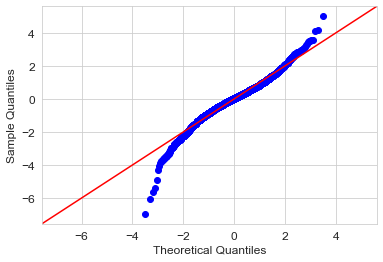

In [71]:
# Making the QQ Plot
residuals3 = (y_test - pred_lr3)
sm.graphics.qqplot(residuals3, dist=stats.norm, line="45", fit=True);

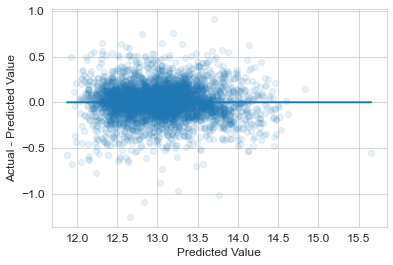

In [72]:
# Checking for homoscedasticity 
residuals3 = (y_test - pred_lr3)
fig, ax = plt.subplots()
ax.scatter(pred_lr3, residuals3, alpha=.1)
ax.plot(pred_lr3, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

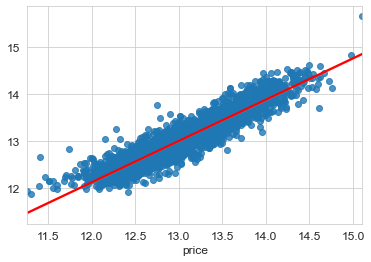

In [73]:
# Checking to see how our regression line fits our data
sns.regplot(x = y_test, y = pred_lr3, data = df, line_kws={'color':'r'});

### Model 4:  dropping features with high p_values


In [74]:
# Use summary above to drop features with high p_values
X = df.drop(['price', 'x_98002', 'x_98003', 'sqft_basement', 'bedrooms'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [76]:
# Predict price with the trained model
pred_lr4 = lr.predict(X_test)

In [77]:
# Using the score method to see how well our model performed based on how we trained it
train_score_lr4 = lr.score(X_train, y_train)
test_score_lr4 = lr.score(X_test, y_test)

In [78]:
# Take a peak at model coef
lr.coef_[0]

0.04865482685085614

In [79]:
# Baseline housing cost without features
lr.intercept_

-56.929814275908264

In [80]:
# Normalizing our price to get an RMSE
rmse_lr4 = mean_squared_error(np.exp(y_test), np.exp(pred_lr4), squared=False)

In [81]:
train_score_lr4, test_score_lr4, rmse_lr4 

(0.8707294122768663, 0.8703728279546661, 121678.15586045684)

In [82]:
# Checking the OLS for values of feature significance
X_train = sm.add_constant(X_train)
sm.OLS(y_train, X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1382.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        20:56:39   Log-Likelihood:                 4887.1
No. Observations:               16905   AIC:                            -9608.
Df Residuals:                   16822   BIC:                            -8966.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -56.9298      7.643     -7.449      0.000     -71.910     -41.949
bathrooms         0.0487      0.003     14.053      0.000       0.042       0.055
sqft_living       0.0001   4.62e-06     30.889      0.000       0.000       0.000
sqft_lot       6.639e-07   4.92e-08     13.484      0.000    5.67e-07     7.6e-07
floors           -0.0360      0.004     -8.807      0.000      -0.044      -0.028
waterfront        0.4673      0.020     23.379      0.000       0.428       0.506
view              0.0630      0.002     27.740      0.000       0.059       0.067
condition         0.0543      0.002     22.116      0.000       0.050       0.059
grade             0.0888      0.002     37.716      0.000       0.084       0.093
sqft_above     8.142e-05   4.85e-06     16.805      0.000    7.19e-05    9.09e-05
yr_renovated   3.764e-05    4.1e-06      9.184      0.000    2.96e-05    4.57e-05
lat               0.5132      0.081      6.338      0.000       0.355       0.672
long             -0.3572      0.056     -6.332      0.000      -0.468      -0.247
sqft_living15  7.612e-05   3.85e-06     19.766      0.000    6.86e-05    8.37e-05
sqft_lot15     1.904e-07    8.1e-08      2.350      0.019    3.16e-08    3.49e-07
age               0.0005   8.24e-05      6.520      0.000       0.000       0.001
x_98004           0.9455      0.029     32.646      0.000       0.889       1.002
x_98005           0.6116      0.031     19.736      0.000       0.551       0.672
x_98006           0.5446      0.025     21.815      0.000       0.496       0.594
x_98007           0.5365      0.032     16.772      0.000       0.474       0.599
x_98008           0.5358      0.030     17.768      0.000       0.477       0.595
x_98010           0.3243      0.026     12.307      0.000       0.273       0.376
x_98011           0.2386      0.040      5.992      0.000       0.161       0.317
x_98014           0.2679      0.044      6.093      0.000       0.182       0.354
x_98019           0.2255      0.043      5.219      0.000       0.141       0.310
x_98022           0.1721      0.023      7.643      0.000       0.128       0.216
x_98023          -0.0618      0.013     -4.826      0.000      -0.087      -0.037
x_98024           0.4287      0.039     10.984      0.000       0.352       0.505
x_98027           0.4654      0.025     18.307      0.000       0.416       0.515
x_98028           0.2026      0.039      5.228      0.000       0.127       0.279
x_98029           0.5617      0.029     19.114      0.000       0.504       0.619
x_98030           0.0528      0.016      3.246      0.001       0.021       0.085
x_98031           0.0604      0.017      3.562      0.000       0.027       0.094
x_98032          -0.0732      0.020     -3.586      0.000      -0.113      -0.033
x_98033           0.6001      0.033     18.104   

In [83]:
# Cross validate our model and find the mean of the training scores
scores_simple_4 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)

In [84]:
scores_simple_4

{'fit_time': array([0.03493953, 0.03390813, 0.034904  , 0.03889441, 0.03390956]),
 'score_time': array([0.00694799, 0.006984  , 0.00598431, 0.00398922, 0.00398946]),
 'test_score': array([0.87208486, 0.86981962, 0.86243019, 0.8660027 , 0.8731103 ]),
 'train_score': array([0.86986928, 0.87072363, 0.87250243, 0.87168149, 0.86989453])}

In [85]:
simple_4_mean = np.mean(scores_simple_4['train_score'])
simple_4_mean_test = np.mean(scores_simple_4['test_score'])

In [86]:
simple_4_mean, simple_4_mean_test

(0.8709342720257345, 0.8686895368551891)

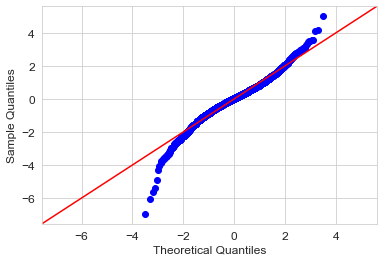

In [87]:
# Checking the normal distribution of our residuals
residuals4 = (y_test - pred_lr4)
sm.graphics.qqplot(residuals4, dist=stats.norm, line="45", fit=True);

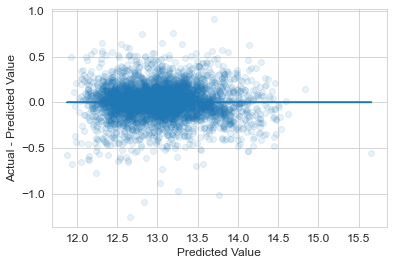

In [88]:
# Checking for homoscedasticity 
residuals4 = (y_test - pred_lr4)
fig, ax = plt.subplots()
ax.scatter(pred_lr4, residuals4, alpha=.1)
ax.plot(pred_lr4, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

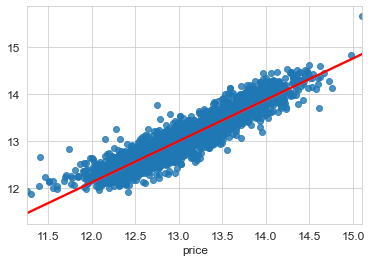

In [89]:
# Checking to see how our regression line fits our data
sns.regplot(x = y_test, y = pred_lr4, data = df, line_kws={'color':'r'});

### Model 5: adding back the zipcodes we dropped in our previous model

In [90]:
# Drop dependent variable and non-relevant features for independent variable
X = df.drop(['price', 'sqft_basement', 'bedrooms'], axis = 1)

# Set independent variable to the natural log of price
y = df['price'] 
y = np.log(y)

# Split our training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [92]:
# Predict price with the trained model
pred_lr5 = lr.predict(X_test)

In [93]:
# Using the score method to see how well our model performed based on how we trained it
train_score_lr5 = lr.score(X_train, y_train)
test_score_lr5 = lr.score(X_test, y_test)

In [94]:
# Take a peak at model coef
lr.coef_[0]

0.04867612612889068

In [95]:
# Baseline housing cost without features
lr.intercept_

-55.805606201770765

In [96]:
# Normalizing our price to get an RMSE
rmse_lr5 = mean_squared_error(np.exp(y_test), np.exp(pred_lr5), squared=False)

In [97]:
train_score_lr5, test_score_lr5, rmse_lr5

(0.8707340916355739, 0.8703683104897879, 121678.04831268311)

In [98]:
# Checking the OLS for values of feature significance
X_train = sm.add_constant(X_train)
sm.OLS(y_train, X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1349.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        20:56:41   Log-Likelihood:                 4887.4
No. Observations:               16905   AIC:                            -9605.
Df Residuals:                   16820   BIC:                            -8947.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -55.8056      7.923     -7.044      0.000     -71.335     -40.277
bathrooms         0.0487      0.003     14.057      0.000       0.042       0.055
sqft_living       0.0001   4.63e-06     30.886      0.000       0.000       0.000
sqft_lot       6.634e-07   4.92e-08     13.474      0.000    5.67e-07     7.6e-07
floors           -0.0360      0.004     -8.791      0.000      -0.044      -0.028
waterfront        0.4674      0.020     23.381      0.000       0.428       0.507
view              0.0630      0.002     27.742      0.000       0.059       0.067
condition         0.0544      0.002     22.126      0.000       0.050       0.059
grade             0.0888      0.002     37.657      0.000       0.084       0.093
sqft_above     8.146e-05   4.85e-06     16.808      0.000     7.2e-05     9.1e-05
yr_renovated   3.767e-05    4.1e-06      9.189      0.000    2.96e-05    4.57e-05
lat               0.5141      0.081      6.345      0.000       0.355       0.673
long             -0.3477      0.059     -5.907      0.000      -0.463      -0.232
sqft_living15  7.602e-05   3.85e-06     19.729      0.000    6.85e-05    8.36e-05
sqft_lot15     1.895e-07    8.1e-08      2.338      0.019    3.06e-08    3.48e-07
age               0.0005   8.25e-05      6.537      0.000       0.000       0.001
x_98002          -0.0143      0.018     -0.776      0.438      -0.050       0.022
x_98003          -0.0033      0.016     -0.198      0.843      -0.035       0.029
x_98004           0.9402      0.030     31.028      0.000       0.881       1.000
x_98005           0.6059      0.032     18.778      0.000       0.543       0.669
x_98006           0.5388      0.027     20.322      0.000       0.487       0.591
x_98007           0.5306      0.033     15.953      0.000       0.465       0.596
x_98008           0.5296      0.032     16.792      0.000       0.468       0.591
x_98010           0.3173      0.028     11.349      0.000       0.263       0.372
x_98011           0.2332      0.041      5.705      0.000       0.153       0.313
x_98014           0.2592      0.045      5.709      0.000       0.170       0.348
x_98019           0.2177      0.044      4.900      0.000       0.131       0.305
x_98022           0.1651      0.024      6.783      0.000       0.117       0.213
x_98023          -0.0653      0.015     -4.282      0.000      -0.095      -0.035
x_98024           0.4206      0.040     10.404      0.000       0.341       0.500
x_98027           0.4587      0.027     16.931      0.000       0.406       0.512
x_98028           0.1975      0.040      4.961      0.000       0.119       0.276
x_98029           0.5546      0.031     17.916      0.000       0.494       0.615
x_98030           0.0475      0.018      2.598      0.009       0.012       0.083
x_98031           0.0551      0.019      2.905   

In [99]:
# Cross validate our model and find the mean of the training scores
scores_simple_5 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)

In [100]:
scores_simple_5

{'fit_time': array([0.04787064, 0.03390861, 0.03889728, 0.03448486, 0.03889227]),
 'score_time': array([0.00598645, 0.00698304, 0.00699806, 0.00698256, 0.00498772]),
 'test_score': array([0.87208694, 0.86981373, 0.86241586, 0.86598991, 0.8730534 ]),
 'train_score': array([0.86987166, 0.87073002, 0.87251058, 0.87168971, 0.86990509])}

In [101]:
simple_5_mean = np.mean(scores_simple_5['train_score'])
simple_5_mean_test = np.mean(scores_simple_5['test_score'])

In [102]:
simple_5_mean, simple_5_mean_test

(0.8709414104386142, 0.8686719681889123)

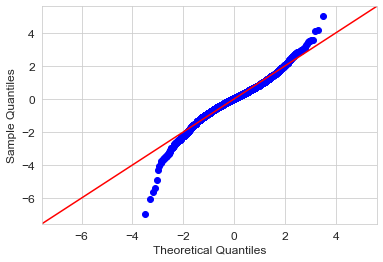

In [103]:
# Checking the normal distribution of our residuals
residuals5 = (y_test - pred_lr5)
sm.graphics.qqplot(residuals5, dist=stats.norm, line="45", fit=True);

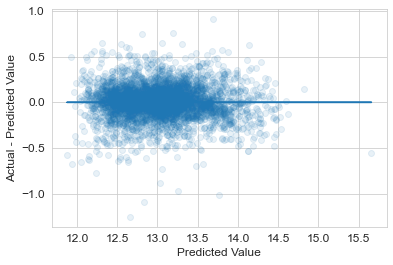

In [104]:
# Checking for homoscedasticity 
residuals5 = (y_test - pred_lr4)
fig, ax = plt.subplots()
ax.scatter(pred_lr5, residuals5, alpha=.1)
ax.plot(pred_lr5, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

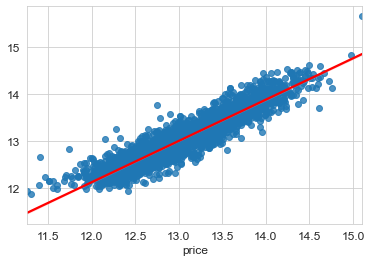

In [105]:
# Checking to see how our regression line fits our data
sns.regplot(x = y_test, y = pred_lr5, data = df, line_kws={'color':'r'});

### Model 6: Our best LR model

In [106]:
# Drop dependent variable and non-relevant features for independent variable
X = df.drop(['price', 'sqft_basement', 'bedrooms', 'sqft_above'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

# Predict price with the trained model
pred_lr6 = lr.predict(X_test)

# Get the coefficient of determination for training and test data
train_score_lr6 = lr.score(X_train, y_train)
test_score_lr6 = lr.score(X_test, y_test)

# Take a peak at model coef
lr.coef_[0]

# Baseline housing cost without features
lr.intercept_

# Normalizing our price to get an RMSE
rmse_lr6 = mean_squared_error(np.exp(y_test), np.exp(pred_lr6), squared=False)

In [108]:
train_score_lr6, test_score_lr6, rmse_lr6

(0.868562897452934, 0.868558305078146, 120124.9421814577)

In [109]:
# Making an OLS table to check for feature significance
X_train = sm.add_constant(X_train)
reg_6 = sm.OLS(y_train, X_train).fit()
reg_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1339.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        20:56:43   Log-Likelihood:                 4746.6
No. Observations:               16905   AIC:                            -9325.
Df Residuals:                   16821   BIC:                            -8676.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -51.9560      7.985     -6.507      0.000     -67.608     -36.304
bathrooms         0.0394      0.003     11.422      0.000       0.033       0.046
sqft_living       0.0002   3.56e-06     54.156      0.000       0.000       0.000
sqft_lot       6.814e-07   4.96e-08     13.727      0.000    5.84e-07    7.79e-07
floors           -0.0018      0.004     -0.508      0.611      -0.009       0.005
waterfront        0.4667      0.020     23.154      0.000       0.427       0.506
view              0.0576      0.002     25.392      0.000       0.053       0.062
condition         0.0506      0.002     20.480      0.000       0.046       0.055
grade             0.0966      0.002     41.429      0.000       0.092       0.101
yr_renovated   3.624e-05   4.13e-06      8.770      0.000    2.81e-05    4.43e-05
lat               0.5170      0.082      6.328      0.000       0.357       0.677
long             -0.3147      0.059     -5.306      0.000      -0.431      -0.198
sqft_living15  8.394e-05   3.86e-06     21.769      0.000    7.64e-05    9.15e-05
sqft_lot15     1.981e-07   8.17e-08      2.425      0.015     3.8e-08    3.58e-07
age               0.0007   8.26e-05      8.374      0.000       0.001       0.001
x_98002          -0.0124      0.019     -0.666      0.505      -0.049       0.024
x_98003          -0.0070      0.017     -0.424      0.672      -0.040       0.025
x_98004           0.9304      0.031     30.456      0.000       0.870       0.990
x_98005           0.5910      0.033     18.171      0.000       0.527       0.655
x_98006           0.5173      0.027     19.371      0.000       0.465       0.570
x_98007           0.5180      0.034     15.450      0.000       0.452       0.584
x_98008           0.5155      0.032     16.214      0.000       0.453       0.578
x_98010           0.3155      0.028     11.190      0.000       0.260       0.371
x_98011           0.2231      0.041      5.415      0.000       0.142       0.304
x_98014           0.2464      0.046      5.383      0.000       0.157       0.336
x_98019           0.2059      0.045      4.596      0.000       0.118       0.294
x_98022           0.1645      0.025      6.702      0.000       0.116       0.213
x_98023          -0.0681      0.015     -4.429      0.000      -0.098      -0.038
x_98024           0.4094      0.041     10.043      0.000       0.329       0.489
x_98027           0.4353      0.027     15.954      0.000       0.382       0.489
x_98028           0.1847      0.040      4.602      0.000       0.106       0.263
x_98029           0.5378      0.031     17.241      0.000       0.477       0.599
x_98030           0.0442      0.018      2.396      0.017       0.008       0.080
x_98031           0.0473      0.019      2.474      0.013       0.010       0.085
x_98032          -0.0871      0.022     -3.919   

In [110]:
# Cross validate our model and find the mean of the training scores
scores_simple_6 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)

In [111]:
scores_simple_6

{'fit_time': array([0.03390837, 0.03291202, 0.04886794, 0.04288602, 0.03690124]),
 'score_time': array([0.00698113, 0.00398922, 0.00398993, 0.0069809 , 0.00698066]),
 'test_score': array([0.86991529, 0.8674618 , 0.8606832 , 0.86368473, 0.87046294]),
 'train_score': array([0.86768549, 0.86859142, 0.87022816, 0.86954633, 0.8678329 ])}

In [112]:
simple_6_mean = np.mean(scores_simple_6['train_score'])
simple_6_mean_test = np.mean(scores_simple_6['test_score'])

In [113]:
simple_6_mean, simple_6_mean_test

(0.8687768600838034, 0.8664415894117834)

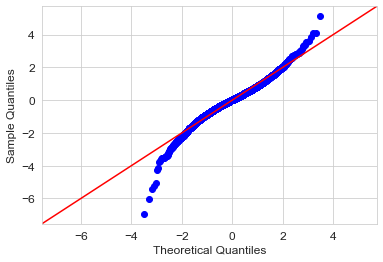

In [114]:
# Making the QQ Plot
residuals6 = (y_test - pred_lr6)
sm.graphics.qqplot(residuals6, dist=stats.norm, line="45", fit=True);

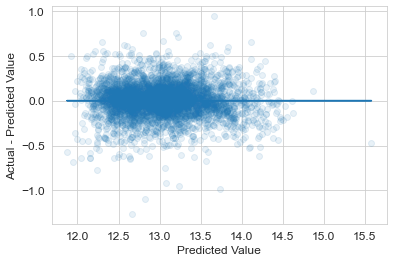

In [115]:
# Checking for homoscedasticity 
residuals6 = (y_test - pred_lr6)
fig, ax = plt.subplots()
ax.scatter(pred_lr6, residuals6, alpha=.1)
ax.plot(pred_lr6, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

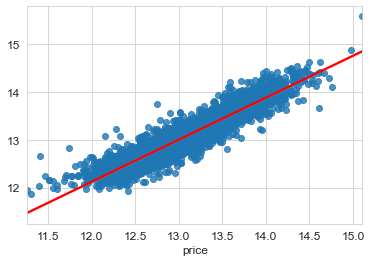

In [116]:
# Checking to see how our regression line fits our data
sns.regplot(x = y_test, y = pred_lr6, data = df, line_kws={'color':'r'});

### Model 7:  Polynomial Regression

In [117]:
# Drop dependent variable and non-relevant features for independent variable
X = df.drop(['price', 'sqft_basement', 'sqft_lot15', 'sqft_above', 'bathrooms', 'sqft_living', 'grade'], axis = 1)
y = df['price'] 

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [119]:
poly = PolynomialFeatures(2)

In [120]:
# Pass in our training dataset
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [121]:
# Initialize an empty regression model
lr = LinearRegression()

In [122]:
# Fits the model to our training dataset
lr.fit(X_train_poly, y_train)

LinearRegression()

In [123]:
# Get the coefficient of determination for training and test data
score_train_poly = lr.score(X_train_poly, y_train)
score_test_poly = lr.score(X_test_poly,y_test)

In [124]:
# Predict price with the trained model
pred_poly = lr.predict(X_test_poly)

In [125]:
# Normalizing our price to get an RMSE
rmse_poly_7 = mean_squared_error(y_test, pred_poly, squared=False)

In [126]:
score_train_poly, score_test_poly, rmse_poly_7

(0.8536421577113898, 0.8052442710349483, 133373.4437971592)

In [128]:
# Cross validate our model and find the mean of the training scores
scores_complex_1 = cross_validate(
                    lr, X_train_poly, y_train, cv=5, 
                    return_train_score=True
)

In [129]:
scores_complex_1

{'fit_time': array([15.0538063 , 15.32612109, 15.32836413, 14.85185027, 14.57310939]),
 'score_time': array([0.01895046, 0.01894975, 0.02194262, 0.01795387, 0.02493382]),
 'test_score': array([   0.72481526, -162.38246217,    0.75922641,    0.7405867 ,
           0.79717434]),
 'train_score': array([0.860354  , 0.85753447, 0.86277007, 0.85564138, 0.85720659])}

In [130]:
scores_complex_1_train = np.mean(scores_complex_1['train_score'])
scores_complex_1_test = np.mean(scores_complex_1['test_score'])

In [131]:
scores_complex_1_test, scores_complex_1_train

(-31.872131890081327, 0.8587013015184425)

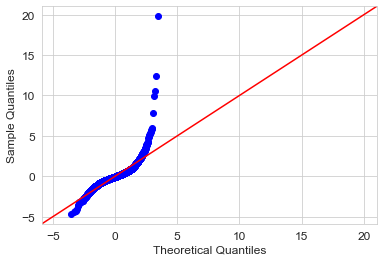

In [132]:
# Checking the normal distribution of our residuals
residuals = (y_test - pred_poly)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

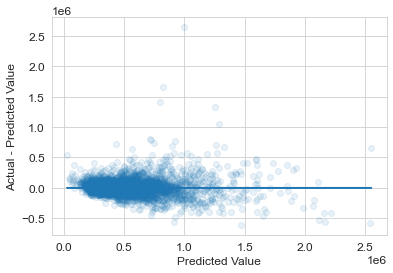

In [133]:
# Checking for homoscedasticity 
residuals = (y_test - pred_poly)
fig, ax = plt.subplots()
ax.scatter(pred_poly, residuals, alpha=.1)
ax.plot(pred_poly, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

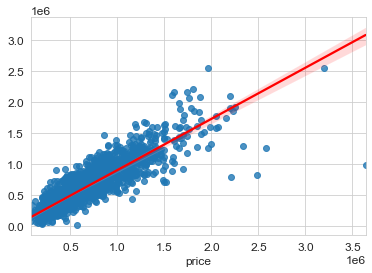

In [134]:
# Checking to see how our regression line fits our data
sns.regplot(x = y_test, y = pred_poly, data = df, line_kws={'color':'r'});

### Model 8: Linear Regression with Feature Engineering

In [135]:
# Feature Engineering Making 4 new colmns - here we are turning grade into a polynomial and multiplying it by existing features which improves the correlation to price compared to using the initial features.
df['grade_sqft_living'] = (df.grade**2) * df.sqft_living
df['grade_sqft_above'] = (df.grade**2) * df.sqft_above
df['grade_sqft_living15'] = (df.grade**2) * df.sqft_living15
df['grade_bathrooms'] = (df.grade**2) * df.bathrooms

In [136]:
# Droping columns that are not going to be used 
X = df.drop(['price', 'sqft_basement', 'sqft_lot15', 'sqft_above', 'bathrooms', 'sqft_living', 'grade'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [137]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [138]:
# Predict price with the trained model
pred_lr8 = lr.predict(X_test)

In [139]:
# Get the coefficient of determination for training and test data
train_score_lr8 = lr.score(X_train, y_train)
test_score_lr8 = lr.score(X_test, y_test)

In [140]:
# Take a peak at model coef
lr.coef_[0]

0.018665680058241374

In [141]:
# Baseline housing cost without features
lr.intercept_

-58.144175791769094

In [142]:
# Normalizing our price to get an RMSE
rmse_lr8 = mean_squared_error(np.exp(y_test), np.exp(pred_lr8), squared=False)

In [143]:
train_score_lr8, test_score_lr8, rmse_lr8 

(0.857820485706503, 0.8582847155879496, 137291.6423007392)

In [144]:
# Making an OLS table to check for feature significance
X_train = sm.add_constant(X_train)
sm.OLS(y_train, X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     1208.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        20:59:22   Log-Likelihood:                 4082.6
No. Observations:               16905   AIC:                            -7995.
Df Residuals:                   16820   BIC:                            -7338.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -58.1442      8.294     -7.010      0.000     -74.401     -41.887
bedrooms                0.0187      0.002      8.672      0.000       0.014       0.023
sqft_lot             7.056e-07   3.98e-08     17.749      0.000    6.28e-07    7.84e-07
floors                 -0.0132      0.004     -3.191      0.001      -0.021      -0.005
waterfront              0.4547      0.021     21.672      0.000       0.414       0.496
view                    0.0646      0.002     26.831      0.000       0.060       0.069
condition               0.0615      0.003     23.941      0.000       0.056       0.067
yr_renovated         4.984e-05   4.29e-06     11.621      0.000    4.14e-05    5.82e-05
lat                     0.5554      0.085      6.536      0.000       0.389       0.722
long                   -0.3551      0.062     -5.766      0.000      -0.476      -0.234
sqft_living15           0.0003   6.92e-06     40.297      0.000       0.000       0.000
age                 -4.479e-05   8.38e-05     -0.534      0.593      -0.000       0.000
x_98002                -0.0228      0.019     -1.182      0.237      -0.061       0.015
x_98003                 0.0078      0.017      0.455      0.649      -0.026       0.042
x_98004                 0.9213      0.032     29.001      0.000       0.859       0.984
x_98005                 0.6183      0.034     18.279      0.000       0.552       0.685
x_98006                 0.5454      0.028     19.625      0.000       0.491       0.600
x_98007                 0.5351      0.035     15.346      0.000       0.467       0.603
x_98008                 0.5304      0.033     16.040      0.000       0.466       0.595
x_98010                 0.3077      0.029     10.492      0.000       0.250       0.365
x_98011                 0.2186      0.043      5.101      0.000       0.135       0.303
x_98014                 0.2409      0.048      5.058      0.000       0.148       0.334
x_98019                 0.2005      0.047      4.300      0.000       0.109       0.292
x_98022                 0.1750      0.026      6.855      0.000       0.125       0.225
x_98023                -0.0580      0.016     -3.624      0.000      -0.089      -0.027
x_98024                 0.4178      0.042      9.854      0.000       0.335       0.501
x_98027                 0.4509      0.028     15.874      0.000       0.395       0.507
x_98028                 0.1826      0.042      4.372      0.000       0.101       0.264
x_98029                 0.5607      0.032     17.296      0.000       0.497       0.624
x_98030                 0.0487      0.019      2.541      0.011       0.011       0.086
x_98031                 0.0498      0.020      2.502      0.012       0.011       0.089
x_98032                -0.0766      0.023     -3.312      0.001      -0.122      -0.031
x_9

In [145]:
# Cross validate our model and find the mean of the training scores
simple_7_mean = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)

In [146]:
simple_7_mean

{'fit_time': array([0.03889489, 0.03786206, 0.04487967, 0.03690052, 0.04388332]),
 'score_time': array([0.0069809 , 0.01895118, 0.00498748, 0.00797915, 0.004987  ]),
 'test_score': array([0.86148303, 0.85586383, 0.8477049 , 0.85302596, 0.8591443 ]),
 'train_score': array([0.85633369, 0.85804963, 0.86000377, 0.8587489 , 0.85717216])}

In [147]:
scores_simple_7 = np.mean(simple_7_mean['train_score'])
simple_7_mean_test = np.mean(simple_7_mean['test_score'])

In [148]:
scores_simple_7, simple_7_mean

(0.8580616293346761,
 {'fit_time': array([0.03889489, 0.03786206, 0.04487967, 0.03690052, 0.04388332]),
  'score_time': array([0.0069809 , 0.01895118, 0.00498748, 0.00797915, 0.004987  ]),
  'test_score': array([0.86148303, 0.85586383, 0.8477049 , 0.85302596, 0.8591443 ]),
  'train_score': array([0.85633369, 0.85804963, 0.86000377, 0.8587489 , 0.85717216])})

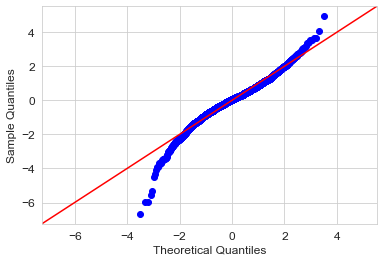

In [149]:
# Checking the normal distribution of our residuals
residuals8 = (y_test - pred_lr8)
sm.graphics.qqplot(residuals8, dist=stats.norm, line="45", fit=True);

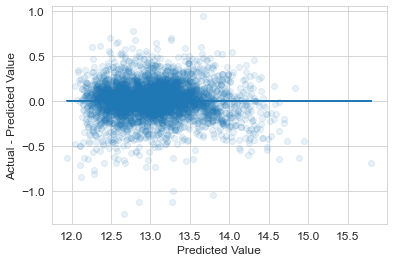

In [150]:
# Checking for homoscedasticity 
residuals8 = (y_test - pred_lr8)
fig, ax = plt.subplots()
ax.scatter(pred_lr8, residuals8, alpha=.1)
ax.plot(pred_lr8, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

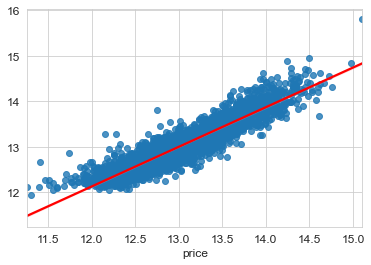

In [151]:
# Checking to see how our regression line fits our data
sns.regplot(x = y_test, y = pred_lr8, data = df, line_kws={'color':'r'});

### Model 9: A Polynomial model with feature engineering

In [152]:
df['grade_sqft_living'] = (df.grade**2) * df.sqft_living
df['grade_sqft_above'] = (df.grade**2) * df.sqft_above
df['grade_sqft_living15'] = (df.grade**2) * df.sqft_living15
df['grade_bathrooms'] = (df.grade**2) * df.bathrooms

In [153]:
# Drop dependent column and those that were used in feature engineering
X = df.drop(['price', 'sqft_basement', 'sqft_lot15', 'sqft_above', 'bathrooms', 'sqft_living', 'grade'], axis = 1)
y = df['price'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [154]:
# Initialize empty polynomial object- 2 degrees
poly = PolynomialFeatures(2)

In [155]:
# Pass in our training dataset
X_train_poly = poly.fit_transform(X_train)

In [156]:
# Pass in our test dataset
X_test_poly = poly.transform(X_test)

In [157]:
# Initialize an empty regression model
lr = LinearRegression()

In [158]:
# Use poly training X and Y data for linear regression model
lr.fit(X_train_poly, y_train)

LinearRegression()

In [159]:
# Get the coefficient of determination for training and test data
score_train_poly = lr.score(X_train_poly, y_train)
score_test_poly = lr.score(X_test_poly,y_test)

In [160]:
# Predict price with the trained model
pred_poly = lr.predict(X_test_poly)

In [161]:
# Calculating the error of our predicted price versus actual
rmse_poly_9 = mean_squared_error(y_test, pred_poly, squared=False)

In [162]:
score_train_poly, score_test_poly, rmse_poly_9 

(0.9148897728056591, 0.8825854557587928, 103558.36677757352)

In [164]:
# Pass in our training dataset
X_poly = poly.fit_transform(X_train)

# Initialize an empty regression model
model_1 = LinearRegression()

# Cross validate our model and find the mean of the training scores
scores_complex_2 = cross_validate(
                    model_1, X_poly, y_train, cv=5, 
                    return_train_score=True
)

In [165]:
scores_complex_2

{'fit_time': array([17.78917885, 17.7282393 , 18.44741917, 17.89015532, 17.66827416]),
 'score_time': array([0.02294016, 0.02094436, 0.02992058, 0.02692795, 0.02194262]),
 'test_score': array([0.85138138, 0.69443154, 0.86135166, 0.87632778, 0.86731032]),
 'train_score': array([0.91819334, 0.91776963, 0.92076593, 0.91587666, 0.91773002])}

In [166]:
scores_complex_2_train = np.mean(scores_complex_2['train_score'])
scores_complex_2_test = np.mean(scores_complex_2['test_score'])

In [167]:
scores_complex_2_train, scores_complex_2_test

(0.9180671148502743, 0.8301605352135033)

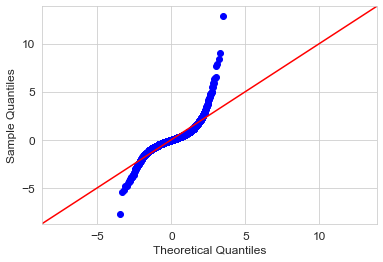

In [168]:
# Checking the normal distribution of our residuals
residuals = (y_test - pred_poly)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

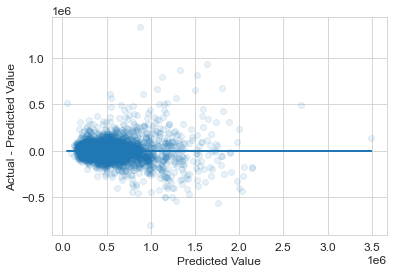

In [169]:
# Checking for homoscedasticity 
residuals = (y_test - pred_poly)
fig, ax = plt.subplots()
ax.scatter(pred_poly, residuals, alpha=.1)
ax.plot(pred_poly, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

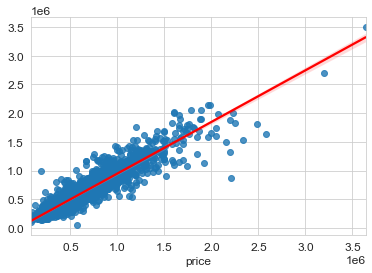

In [170]:
# Checking to see how our regression line fits our data
sns.regplot(x = y_test, y = pred_poly, data = df, line_kws={'color':'r'});

# Checking the RMSE for all the Models

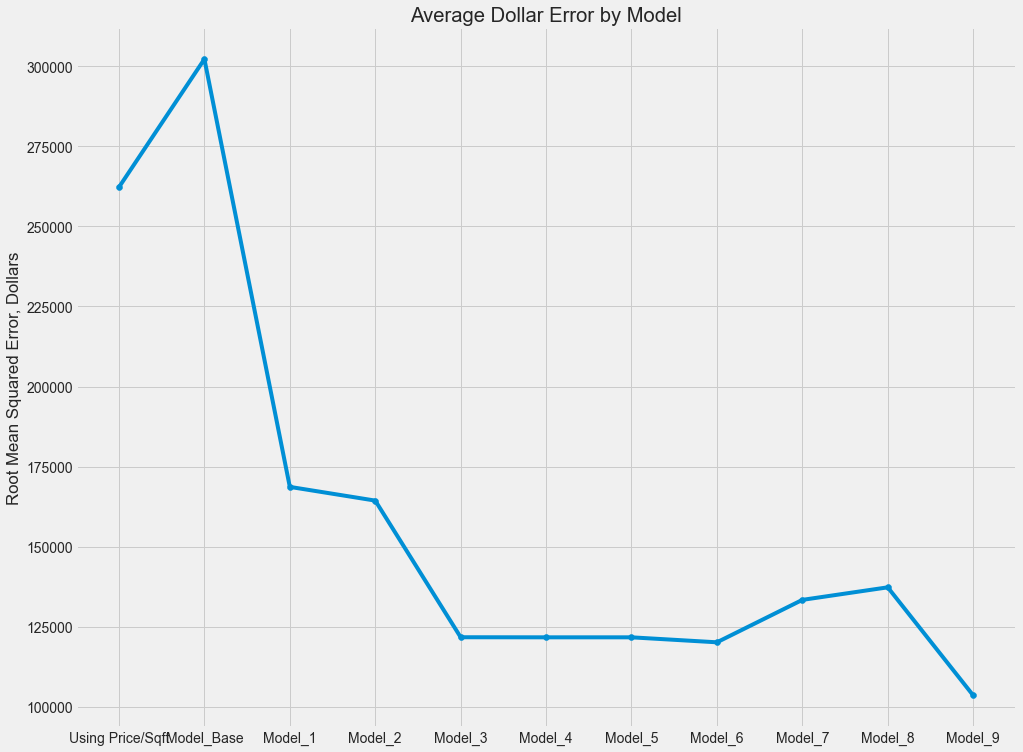

In [171]:
# plotting the RMSE's for each of the models we created - the RMSE's represent the difference between our actual test scores vs. our predicted test scores

models = ['Using Price/Sqft', 'Model_Base', 'Model_1', 'Model_2', 'Model_3', 'Model_4', 'Model_5', 
          'Model_6', 'Model_7', 'Model_8', 'Model_9']
RMSE = [rmse_base, rmse_lr0, rmse_lr1, rmse_lr2, rmse_lr3, rmse_lr4, 
        rmse_lr5, rmse_lr6, rmse_poly_7, rmse_lr8, rmse_poly_9]
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,12))
ax.plot(models, RMSE);
ax.scatter(models, RMSE);
ax.set_ylabel('Root Mean Squared Error, Dollars')
ax.set_title('Average Dollar Error by Model');

# Comparing Price/sqft and our best Model

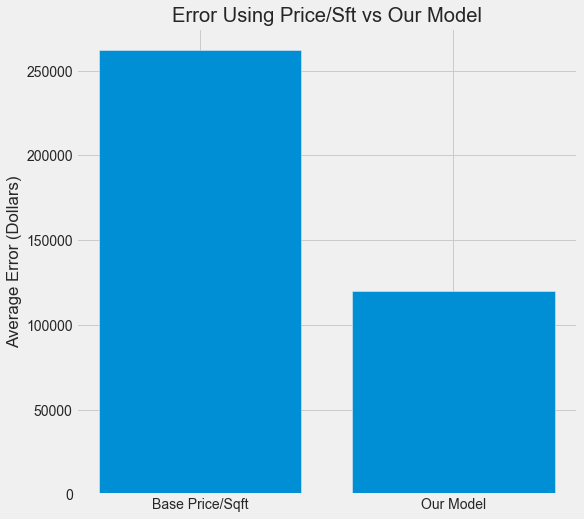

In [172]:
# Plotting Error of base price / sqft and Model 6
fig, ax = plt.subplots(figsize=(8,8))
x = ['Base Price/Sqft', 'Our Model']
y = [rmse_base, rmse_lr6]
ax.bar(x, y)
ax.set_ylabel('Average Error (Dollars)')
ax.set_title('Error Using Price/Sft vs Our Model');

# Printing out all the scores and comparing them

In [173]:
# Making an array of all the train score means for our cross e-vals
x_ = np.array([simple_1_mean,
    simple_2_mean,
    simple_3_mean,
    simple_4_mean,
    simple_5_mean,
    simple_6_mean,
    scores_complex_1_train,
    scores_simple_7,
    scores_complex_2_train])

In [174]:
# counter
p = 0

# Using a for loop to print out every train score
for i in x_:
    p += 1
    print(f'The Train Score is {round(i, 3)} in model {p}')
print('\n')
# Getting the train score that was the highest
print(f'The Max Train score is {x_.max()}')

The Train Score is 0.692 in model 1
The Train Score is 0.756 in model 2
The Train Score is 0.871 in model 3
The Train Score is 0.871 in model 4
The Train Score is 0.871 in model 5
The Train Score is 0.869 in model 6
The Train Score is 0.859 in model 7
The Train Score is 0.858 in model 8
The Train Score is 0.918 in model 9


The Max Train score is 0.9180671148502743


In [175]:
# Making an array of all the test scores for our cross e-vals
y_ = np.array([simple_1_mean_test,
    simple_2_mean_test,
    simple_3_mean_test,
    simple_4_mean_test,
    simple_5_mean_test,
    simple_6_mean_test,
    scores_complex_1_test,
    simple_7_mean_test,
    scores_complex_2_test])

In [176]:
# Counter
m = 0

# Using a for loop to print out every test score
for i in y_:
    m += 1
    # to check if the test score is positive
    if i <= 0:
        print(f'{round(i, 3)} is not accurate for model {m}\n')
    else:
        print(f'The Test score is {round(i, 3)} in model {m}\n')
print('\n')

# Return the hightest test score
print(f'The highest test score is {y_.max()}')    

The Test score is 0.69 in model 1

The Test score is 0.755 in model 2

The Test score is 0.869 in model 3

The Test score is 0.869 in model 4

The Test score is 0.869 in model 5

The Test score is 0.866 in model 6

-31.872 is not accurate for model 7

The Test score is 0.855 in model 8

The Test score is 0.83 in model 9



The highest test score is 0.8686895368551891


In [177]:
# Making an arrray of the RMSE
z_ = np.array([rmse_lr0,
               rmse_lr1,
               rmse_lr2,
               rmse_lr3,
               rmse_lr4,
               rmse_lr5,
               rmse_lr6,
               rmse_poly_7,
               rmse_lr8,
               rmse_poly_9]
             )

In [178]:
# counter
b = 0

# Using a for loop to return the RMSE for all the models
for i in z_:
    b += 1
    print(f'The RMSE score is {round(i, 3)} in model {b}\n')
print('\n')
# Getting the lowest RMSE
print(f'The lowest RMSE score is {z_.min()}')  

The RMSE score is 302249.836 in model 1

The RMSE score is 168660.863 in model 2

The RMSE score is 164378.886 in model 3

The RMSE score is 121705.585 in model 4

The RMSE score is 121678.156 in model 5

The RMSE score is 121678.048 in model 6

The RMSE score is 120124.942 in model 7

The RMSE score is 133373.444 in model 8

The RMSE score is 137291.642 in model 9

The RMSE score is 103558.367 in model 10



The lowest RMSE score is 103558.36677757352


# Finding the best Parameters and Features in Model 6

After building and testing our best model we found that one of the features that most affected our price was the **zip code** where someone lived. The other feature that most affected price was **latitude**. Both these features show that location is a key determinate of what the price of a house would be. Our best model also showed that the features that were the worst at determining price were the **number of floors** a house has and the **lot size of the 15 closest neighbors**. This model was able to explain *86.9%* of the variation in house prices it had been trained on and was able to explain *86.6%* of the variation on house prices it had never seen. This is an error of *0.02%* exists between our train and test data. This shows us that our model is not overfitting the data and would be reasonable in explaining the variance of a price it has not seen before. The **RMSE** of the model is *$121,678.05*, though this is not an appropriate amount of error for a model to predict house prices it would certainly not be as bad as expected for a linear regression model.

# Advanced Models with Sklearn

In [179]:
# Drop dependent variable and non-relevant features for independent variable
X = df.drop(['price', 'sqft_basement', 'bedrooms', 'sqft_above'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [180]:
# Import Random Forest
from sklearn.ensemble import RandomForestRegressor
# Call Random Forest and set the estimators to 150
rf = RandomForestRegressor(n_estimators=150)
# Fit the model
rf.fit(X_train, y_train)
# Get the scores
score_rf = rf.score(X_train, y_train)
score_rf_test = rf.score(X_test, y_test)
# Get the predictions
predict_rf = rf.predict(X_test)

rmse_rfr = mean_squared_error(np.exp(y_test),np.exp(predict_rf), squared=False)
score_rf, score_rf_test, rmse_rfr

(0.9827502460015034, 0.886528783343554, 108727.77712458103)

In [181]:
# Import ensemble
from sklearn import ensemble
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.06, 
                                         n_estimators = 600, max_depth = 5)
gbr.fit(X_train, y_train)
gbr_train = gbr.score(X_train, y_train)
gbr_test = gbr.score(X_test, y_test)
pred_gbr = gbr.predict(X_test)
rmse_gbr = mean_squared_error(np.exp(y_test), np.exp(pred_gbr), squared=False)
gbr_train, gbr_test, rmse_gbr

(0.9443265870733917, 0.9014814876174909, 96415.1401625992)

In [182]:
df.drop(['grade_sqft_living', 'grade_sqft_above', 'grade_sqft_living15', 'grade_bathrooms'], axis = 1, inplace = True)

In [183]:
# Call Random Forest and set the estimators to 150
rf = RandomForestRegressor(n_estimators=150)
# Fit the model
rf.fit(X_train, y_train)
# Get the scores
score_rf = rf.score(X_train, y_train)
score_rf_test = rf.score(X_test, y_test)
# Get the predictions
predict_rf = rf.predict(X_test)

rmse_rfr = mean_squared_error(np.exp(y_test),np.exp(predict_rf), squared=False)
score_rf, score_rf_test, rmse_rfr

(0.9829553921696436, 0.8864051089841987, 108784.24967642789)

In [184]:
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.06, 
                                         n_estimators = 600, max_depth = 5)
gbr.fit(X_train, y_train)
gbr_train = gbr.score(X_train, y_train)
gbr_test = gbr.score(X_test, y_test)
pred_gbr = gbr.predict(X_test)
rmse_gbr = mean_squared_error(np.exp(y_test), np.exp(pred_gbr), squared=False)
gbr_train, gbr_test, rmse_gbr

(0.9443265870733917, 0.9013802374340742, 96481.93099478706)

In [186]:
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.06, 
                                         n_estimators = 600, max_depth = 5, loss='huber')
gbr.fit(X_train, y_train)
gbr_train = gbr.score(X_train, y_train)
gbr_test = gbr.score(X_test, y_test)
pred_gbr = gbr.predict(X_test)
rmse_gbr = mean_squared_error(np.exp(y_test), np.exp(pred_gbr), squared=False)
gbr_train, gbr_test, rmse_gbr

(0.939024812287243, 0.9007154895423287, 96160.455863526)

In [187]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 586.0236358642578 seconds ---
